### Script to rename file names in the dataset
This will remove the word Image and Mask from each file name

In [1]:
def remove_word(file_name, word):
    """ Returns a new file_name with word removed from it
        Input:
            file_name: string (only file name NOT the path)
            word: word with which to remove
    """
    return file_name.replace(word, '')

In [2]:
import re
def white_space_to_underscore(file_name):
    """ Returns a new file_name with all white spaces removed
        Input:
            file_name: string (only file name NOT the path)
    """
    return re.sub(r'(\s|_)+', '_', file_name.strip())

In [3]:
import os
from functools import reduce

def apply_renames(directory, fns):
    """ Iterates over a directory and renames each file according to the functions in order
        Input:
            directory: string
            fns: List<(string -> )>
    """
    for filename in os.listdir(directory):
        new_filename = reduce(lambda acc, fn: fn(acc), fns, filename)
        old_path = os.path.join(directory, filename)
        new_path = os.path.join(directory, new_filename)
        os.rename(old_path, new_path)

Executed 2/22/2024 3:47pm

In [7]:
masks_dir = "data/_Masks"
img_dir = "data/_Original"

mask_renames = [
    lambda filename: remove_word(filename, "Mask"),
    white_space_to_underscore,
]

image_renames = [
    lambda filename: remove_word(filename, "Image"),
    lambda filename: remove_word(filename, "image"),
    white_space_to_underscore,
]

apply_renames(masks_dir, mask_renames)
apply_renames(img_dir, image_renames)

In [25]:
from enum import Enum
import torch

class MaskType(Enum):
    ''' Charachterizes the type of label
    '''
    SEGMENTED = 1  # Segmented but have values {1, 2} (Nx, Ny)
    PROBABILITIES_0 = 2 # Segmented with probabilistic values [0, 1] (C, Nx, Ny) with foreground as 0
    PROBABILITIES_1 = 3 # Segmented with probabilistic values [0, 1] (C, Nx, Ny) with foreground as 1
    BINARY = 4 # Ideal input for the model with values [0, 1] (Nx, Ny)

def get_mask_type(mask, file_name):
    assert mask.dim() == 3
    
    if mask.shape[0] == 2:
        if "SH" in file_name or "YH" in file_name:
            return MaskType.PROBABILITIES_1
        if 'ACC_mask' in file_name:
            return MaskType.PROBABILITIES_1
        if "ACC" in file_name:
            return MaskType.PROBABILITIES_0

    min_val = torch.min(mask)
    max_val = torch.max(mask)

    if min_val == max_val:
        assert Exception("Unable to classify mask, all values are the same")

    if min_val == 1 and max_val == 2:
        return MaskType.SEGMENTED

    if min_val == 0 and max_val == 1:
        return MaskType.BINARY
    

def probability_1_to_binary(mask):
    binary = mask[0]
    binary = binary > 0.5
    binary = binary.long()
    return binary

def probability_0_to_binary(mask):
    binary = mask[1]
    binary = binary > 0.5
    binary = binary.long()
    return binary

def segmented_to_binary(mask):
    binary = mask
    binary[binary == 2] = 0
    binary = binary.squeeze(0)
    binary = binary.long()
    return binary

In [26]:
import utils

def convert_to_binary(mask, file_name):
    mask_type = get_mask_type(mask, file_name)
    match mask_type:
        case MaskType.BINARY:
            return mask
        case MaskType.PROBABILITIES_0:
            return probability_0_to_binary(mask)
        case MaskType.PROBABILITIES_1:
            return probability_1_to_binary(mask)
        case MaskType.SEGMENTED:
            return segmented_to_binary(mask)

def convert_file_to_binary(file_name, new_file_name):
    assert file_name.endswith('.h5')
    assert new_file_name.endswith('.pt')
    tensor = utils.get_h5_tensor(file_name)
    bin_tensor = convert_to_binary(tensor, file_name)
    assert bin_tensor.dim() == 2
    torch.save(bin_tensor, new_file_name)

def transform_directory(directory_name, new_directory_name):
    for file_name in os.listdir(directory_name):
        name, _ = os.path.splitext(file_name)
        new_file_name = name + '.pt'
        new_file_path = os.path.join(new_directory_name, new_file_name)
        file_path = os.path.join(directory_name, file_name)
        print(file_name)
        convert_file_to_binary(file_path, new_file_path)

In [27]:
old_directory = '/projectnb/dunlop/chrisdc/gva_senior_design/image_processing/data/_Masks'
new_directory = '/projectnb/dunlop/chrisdc/gva_senior_design/image_processing/data/labels'
transform_directory(old_directory, new_directory)

ACC_mask8.h5
SH_10.h5
ACC_2.h5
SH_7.h5
ACC_mask7.h5
ACC_mask11.h5
SH_5.h5
ACC_mask2.h5
ACC_mask13.h5
ACC_4.h5
SH_3.h5
YH_7.h5
SH_1.h5
ACC_mask3.h5
YH_5.h5
SH_11.h5
YH_3.h5
ACC_mask4.h5
ACC_3.h5
YH_1.h5
SH_8.h5
ACC_mask1.h5
ACC_5.h5
SH_6.h5
SH_4.h5
ACC_1.h5
ACC_mask6.h5
YH_8.h5
SH_2.h5
ACC_mask9.h5
YH_6.h5
ACC_mask12.h5
ACC_mask5.h5
YH_4.h5
YH_2.h5
SH_9.h5


36


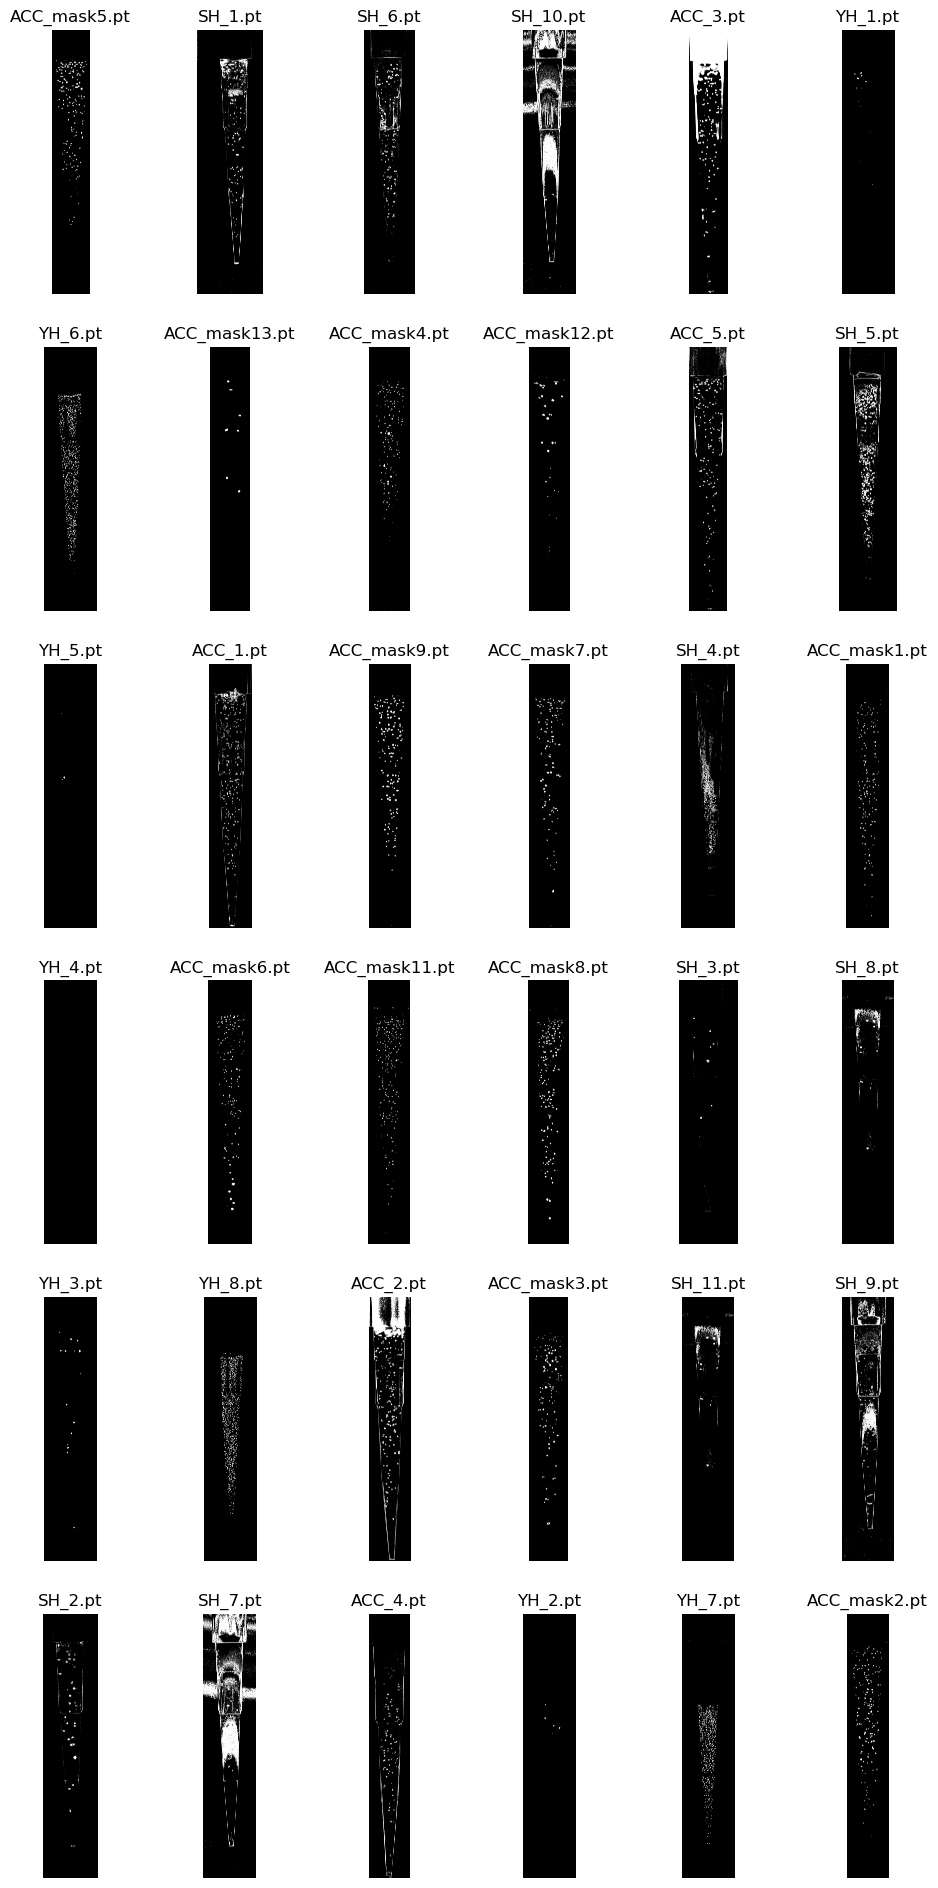

In [31]:
import matplotlib.pyplot as plt
print(len(os.listdir(new_directory)))
fig, ax = plt.subplots(6, 6, figsize=(12, 24))
for i, file in enumerate(os.listdir(new_directory)):
    path = os.path.join(new_directory, file)
    x = torch.load(path)

    r = i // 6
    c = i % 6
    ax[r][c].imshow(x, cmap='gray')
    ax[r][c].set_title(file)
    ax[r][c].axis('off')

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0700],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
prob
segmented
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


(-0.5, 1229.5, 6239.5, -0.5)

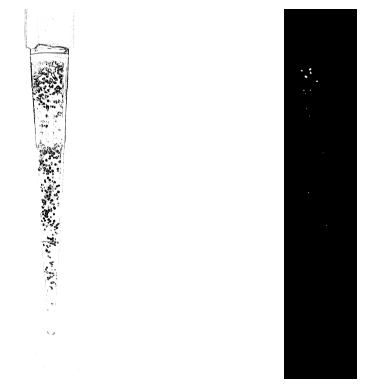

In [110]:
''' Test conversion
'''
import matplotlib.pyplot as plt
import os

prob_mask_filename = "data/masks/_Masks/SH_5.h5"
seg_mask_filename = "data/masks/_Masks/YH_1.h5"
aiden_file = 'data/masks/_Masks/ACC_1.h5'


prob_tensor = utils.get_h5_tensor(prob_mask_filename)
seg_tensor = utils.get_h5_tensor(seg_mask_filename)

print(prob_tensor[0])

bin_tensor1 = convert_to_binary(prob_tensor)
bin_tensor2 = convert_to_binary(seg_tensor)

print(bin_tensor1[20:30, 20:30])

fig, ax = plt.subplots(1, 2)
ax[0].imshow(bin_tensor1, cmap='gray')
ax[0].axis('off')
ax[1].imshow(bin_tensor2, cmap='gray')
ax[1].axis('off')

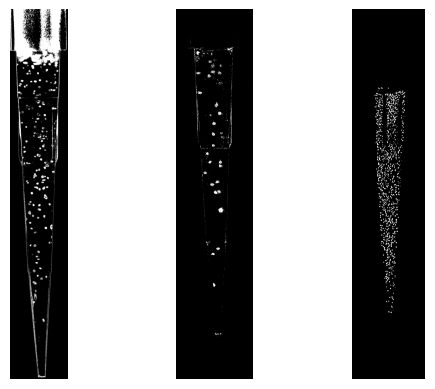

In [23]:
''' Test Script
'''
import matplotlib.pyplot as plt

base_dir = '/projectnb/dunlop/chrisdc/gva_senior_design/image_processing/data/labels'
files = ['ACC_2.pt', 'SH_2.pt', 'YH_8.pt']
files = [os.path.join(base_dir, file) for file in files]
tensors = [torch.load(file) for file in files]


fig, ax = plt.subplots(1, len(files))
for i in range(len(files)):
    ax[i].imshow(tensors[i], cmap='gray')
    ax[i].axis('off')


## Move files

In [13]:
import os

base_dir = '/projectnb/dunlop/chrisdc/gva_senior_design/image_processing/data/aidan_masks'
label_dir = '/projectnb/dunlop/chrisdc/gva_senior_design/image_processing/data/_Masks'
img_dir = '/projectnb/dunlop/chrisdc/gva_senior_design/image_processing/data/_Original'
for file_name in os.listdir(base_dir):
    path = os.path.join(base_dir, file_name)
    if file_name.endswith(('.jpg', '.jpeg', '.png')):
        new_path = os.path.join(img_dir, file_name)
    elif file_name.endswith('.h5'):
        new_path = os.path.join(label_dir, file_name)
    else:
        raise Exception("Invalid file extension")

    os.rename(path, new_path)